In [1]:
from matplotlib import pyplot as plt
from matplotlib import cm as cm
import pandas as pd
import networkx as nx
import numpy as np
import itertools
import random
import time

In [2]:
import sage.all
from sage.graphs.graph import Graph

In [3]:
import sys
import os

In [4]:
script_dir = os.path.abspath('./algorithms/')
sys.path.append(script_dir)

In [5]:
import brute_force as bf
import genetic_algorithms as ga
import s_metaheuristics as sm
import interval_graph_check as igc
import particle_swarm_optimization as pso

### Brute force - plot

In [6]:
test_graphs = {
    "g1": [(0, 1), (1, 2), (2, 3), (3, 0)],
    "g2": [(0, 1), (1, 2), (2, 3), (3, 4)],
    "g3": [(0, 1), (1, 2), (2, 3), (3, 4), (0, 2)],
    "g4": [(1, 2), (2, 3), (2, 5), (2, 6), (3, 4), (5, 6)],
    "i1": [(0, 1), (1, 2), (2, 3)],
    "i2": [(0, 1), (0, 2), (0, 3), (0, 4)],
    "i3": [(0, 1), (1, 2), (2, 0)],
    "i4": [(0, 1), (1, 2), (2, 3)],
    "i5": [(0, 1), (0, 2), (1, 2), (1, 3), (2, 3)],
    "i6": [(0, 1), (0, 3), (0, 6), (1, 2), (1, 3), (1, 4), (1, 6), (2, 4), (2, 6), (3, 4), (3, 5), (3, 6), (4, 5), (4, 6), (5, 6), (6, 7)],
    #"gA": [(0, 1), (1, 2), (1, 5), (2, 3), (2, 6), (3, 4), (3, 7), (5, 6), (6, 7), (7, 8)],
    #"gB": [(0, 1), (0, 3), (0, 6), (1, 2), (1, 3), (1, 4), (1, 6), (2, 4), (2, 6), (3, 4), (3, 5), (3, 6), (4, 5), (6, 7)]
}

In [7]:
gA =  [(0, 1), (1, 2), (1, 5), (2, 3), (2, 6), (3, 4), (3, 7), (5, 6), (6, 7), (7, 8)]
gB = [(0, 1), (0, 3), (0, 6), (1, 2), (1, 3), (1, 4), (1, 6), (2, 4), (2, 6), (3, 4), (3, 5), (3, 6), (4, 5), (6, 7)]

In [8]:
def plot_bf(name, G):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))

    start_time = time.time()
    added_edges, G_minimal = bf.brute_force_min_interval_completion(G)
    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f"Graf: {name}")
    if added_edges is None:
        print("Initial graph is already an interval graph")
    else:
        print(f"Added edges: {added_edges}")
    print(f"Execution time: {elapsed_time:.4f} s")
    print("\n")

    # Plotting initial graph
    plot_G = G.plot(figsize=(8, 8), vertex_size=500, edge_color='blue', graph_border=False)

    # Plotting modified graph
    if added_edges is None:
        plot_G_min = G.plot(figsize=(8, 8), vertex_size=500, edge_color='blue', graph_border=False)
    else:
        plot_G_min = G_minimal.plot(figsize=(8, 8), vertex_size=500, edge_color='red', graph_border=False)

    # Adding graphs to subplots
    plot_G.matplotlib(figure=fig, sub=ax[0])
    ax[0].set_title(f"Initial Graph: {name}")
    ax[0].axis('off')

    plot_G_min.matplotlib(figure=fig, sub=ax[1])
    ax[1].set_title(f"Modified Graph: {name}")
    ax[1].axis('off')

    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.show()

Graf: g1
Added edges: ((0, 2),)
Execution time: 0.0087 s




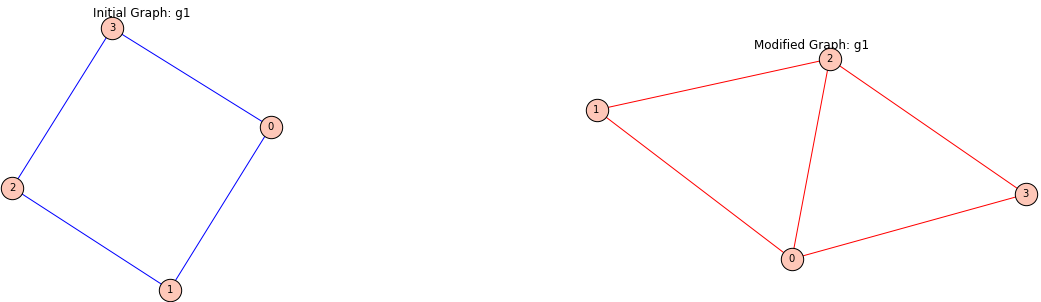

Graf: g2
Added edges: ((1, 3),)
Execution time: 0.1080 s




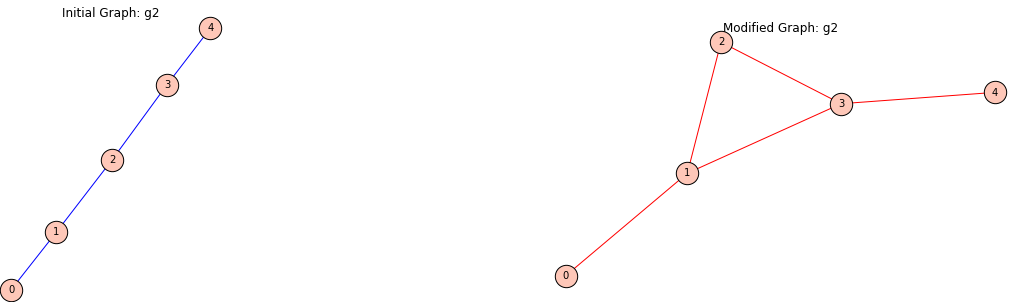

Graf: g3
Added edges: ((0, 3),)
Execution time: 0.1233 s




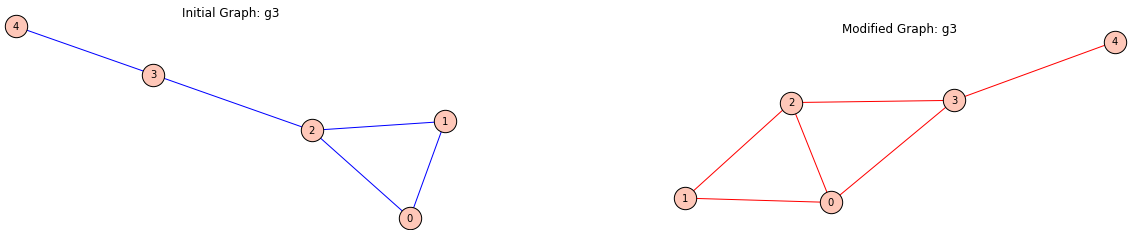

Graf: g4
Added edges: ((3, 6),)
Execution time: 3.5675 s




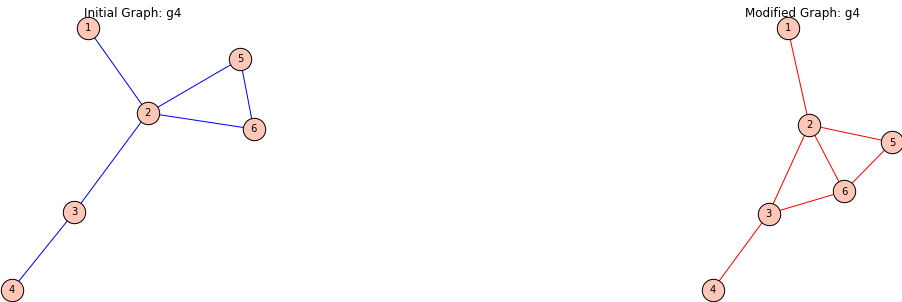

Graf: i1
Initial graph is already an interval graph
Execution time: 0.0002 s




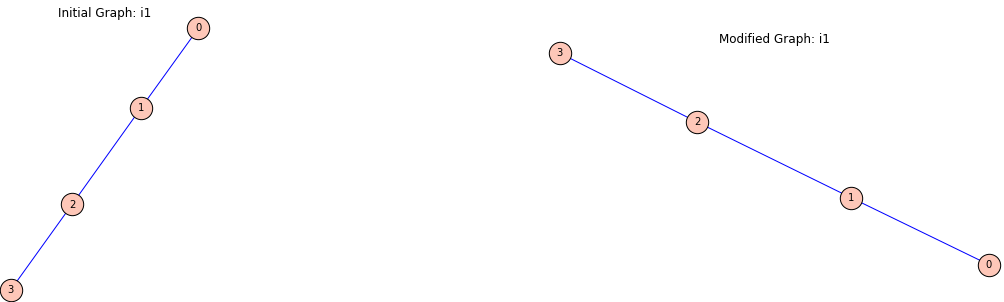

Graf: i2
Initial graph is already an interval graph
Execution time: 0.0003 s




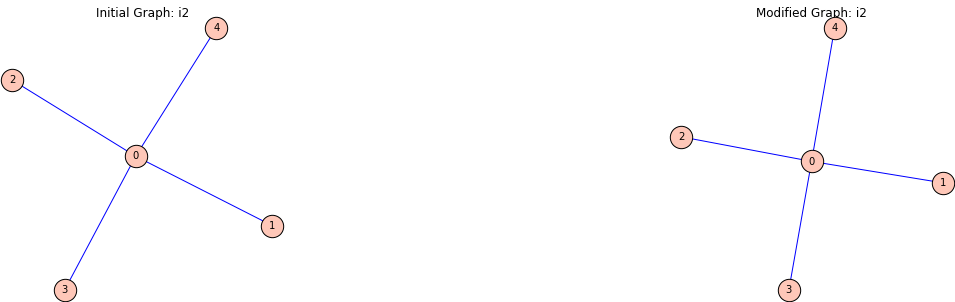

Graf: i3
Initial graph is already an interval graph
Execution time: 0.0002 s




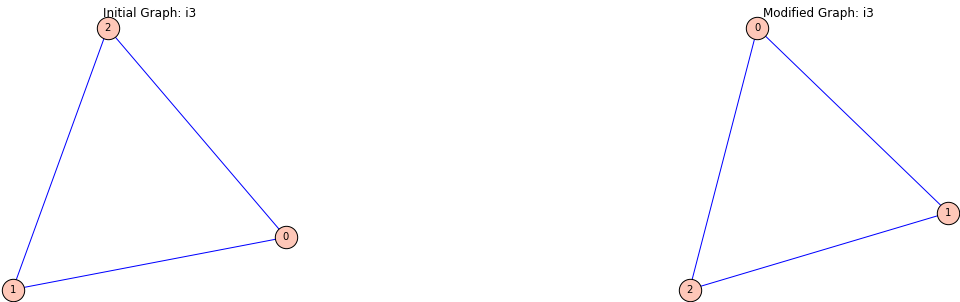

Graf: i4
Initial graph is already an interval graph
Execution time: 0.0003 s




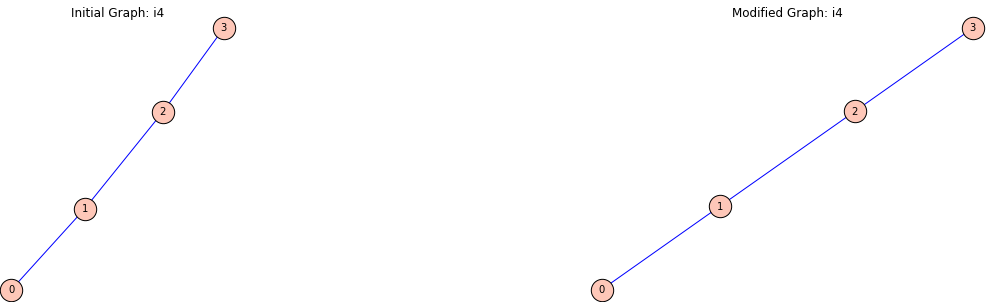

Graf: i5
Initial graph is already an interval graph
Execution time: 0.0009 s




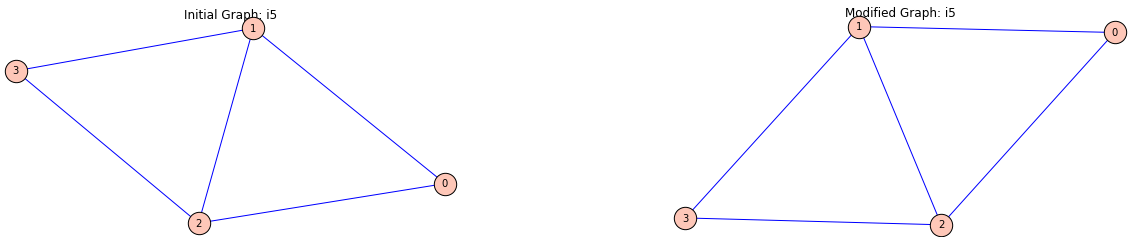

Graf: i6
Initial graph is already an interval graph
Execution time: 0.0003 s




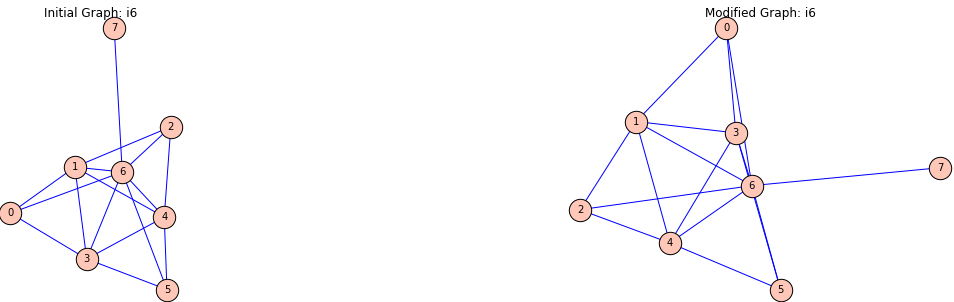

In [9]:
for name, G in test_graphs.items():
    plot_bf(name, Graph(G))

### Simulated annealing - plot

In [10]:
def plot_sa(G):

    print("Simulated annealing")
    print("\n")
    
    start_time = time.time()

    added_edges, G_minimal, values = sm.simulated_annealing(G, num_iters=20000)

    end_time = time.time()
    elapsed_time = end_time - start_time
    
    check, _ = igc.check_interval_graph(G_minimal)
    if not check:
        print("No result found")
        print(f"Execution time: {elapsed_time:.4f} s")
        print("\n")
    
    else:
        print(f"Initial graph: {G.edges(labels=False)}")
        if added_edges is None:
            print("Initial graph is already an interval graph")
            print('\n')
        else:
            print(f"Added edges: {added_edges}")
        print(f"Execution time: {elapsed_time:.4f} s")
        print("\n")

        # Plotting initial graph
        plot_G = G.plot(figsize=(8, 8), vertex_size=500, edge_color='blue', graph_border=False)

        # Plotting modified graph
        if added_edges is None:
            plot_G_min = G.plot(figsize=(8, 8), vertex_size=500, edge_color='blue', graph_border=False)
        else:
            plot_G_min = G_minimal.plot(figsize=(8, 8), vertex_size=500, edge_color='red', graph_border=False)

        # Create figure and subplots
        fig, axes = plt.subplots(1, 3, figsize=(24, 8))

        # Adding graphs to subplots
        plot_G.matplotlib(figure=fig, sub=axes[0])
        axes[0].set_title("Initial Graph")
        axes[0].axis('off')

        plot_G_min.matplotlib(figure=fig, sub=axes[1])
        axes[1].set_title("Modified Graph")
        axes[1].axis('off')

        # Plotting the solution values after the algorithm completes
        if values and any(val is not None for val in values):
            # Remove None values and plot
            clean_values = [val if val is not None else 0 for val in values]
            axes[2].plot(range(len(clean_values)), clean_values)
            axes[2].set_title('Simulated Annealing Progress')
            axes[2].set_xlabel('Steps')
            axes[2].set_ylabel('Solution Value')
            axes[2].set_ylim(bottom=0)  # Ensure y-axis starts from 0
        else:
            # Plot a horizontal line at y=0
            axes[2].axhline(y=0, color='black', linestyle='--')
            axes[2].set_title('Simulated Annealing Progress (No Added Edges)')
            axes[2].set_xlabel('Steps')
            axes[2].set_ylabel('Solution Value')
            axes[2].set_ylim(bottom=0)  # Ensure y-axis starts from 0

        plt.subplots_adjust(wspace=0.5, hspace=0.5)
        plt.show()

### Simulated annealing - cooling plot

In [11]:
cooling_params = {
    't_max_values' : [1000, 5000],
    't_min' : 1,
    'step_max' : 20000,
    'alpha' : 0.95
}

In [12]:
def plot_sa_cooling(G, cooling_params):
    
    print("Simulated annealing - cooling")
    print("\n")
    
    cooling_methods = {
        'linear_multiplicative': sm.linear_multiplicative_cooling,
        'natural_log_exponential_multiplicative': sm.natural_log_exponential_multiplicative_cooling,
        'logarithmic_multiplicative': sm.logarithmic_multiplicative_cooling,
        'quadratic_multiplicative': sm.quadratic_multiplicative_cooling,
        'linear_additive': sm.linear_additive_cooling,
        'exponential_additive': sm.exponential_additive_cooling,
        'quadratic_additive': sm.quadratic_additive_cooling
    }

    t_max_values = cooling_params['t_max_values']
    t_min = cooling_params['t_min']
    step_max = cooling_params['step_max']
    alpha = cooling_params['alpha']

    acceptance_rates = {t_max: [] for t_max in t_max_values}
    labels = list(cooling_methods.keys())
    colors = plt.cm.viridis(np.linspace(0, 1, len(t_max_values)))  # Use a colormap to get distinct colors

    check, _ = igc.check_interval_graph(G)
    if check:
        print('Graph is already interval graph')
        print('\n')
    else:
        # Prepare plots
        fig, axs = plt.subplots(len(cooling_methods), len(t_max_values), figsize=(15, 15), sharex=True)
        fig.suptitle('Simulated Annealing Performance for Different Cooling Methods and Temperatures')

        for i, (name, cooling_func) in enumerate(cooling_methods.items()):
            for j, t_max in enumerate(t_max_values):
                
                start_time = time.time()
                
                best_state, G_minimal, values, best_energy, acceptance_rate = sm.simulated_annealing_cooling(
                    G, cooling_func, t_max=t_max, t_min=t_min, step_max=step_max, alpha=alpha
                )

                end_time = time.time()
                elapsed_time = end_time - start_time
                                  
                # Replace 'inf' values with NaN for plotting
                values = [v if v != float('inf') else np.nan for v in values]

                # Store acceptance rate for the current t_max
                acceptance_rates[t_max].append(acceptance_rate)

                # Print the best number of added edges
                print(f"Cooling Method: {name}")
                print(f't_max={t_max}, Best Number of Added Edges: {best_energy}, Acceptance rate: {acceptance_rate}')
                print(f"Execution time: {elapsed_time:.4f} s")
                print("-------------------------------")

                # Plot number of added edges
                ax = axs[i, j]
                ax.scatter(range(len(values)), values, color=colors[j], label=f't_max={t_max}')  # Scatter plot to handle NaN values
                ax.set_title(f'{name}')
                ax.set_xlabel('Step')
                ax.set_ylabel('Number of Added Edges')
                ax.legend()

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

        # Plotting the acceptance rates as grouped bar charts
        fig, ax = plt.subplots(figsize=(15, 8))  # Increased the size of the plot

        # Define width of bars and positions for each group
        bar_width = 0.05
        positions = np.arange(len(t_max_values))

        # Hatch patterns for inf values
        hatches = ['//', '\\\\', '||', '++', 'xx', 'oo', '--']

        tolerance = 1e-10  # Define a small tolerance

        # Plot each cooling method's acceptance rates
        for i, name in enumerate(labels):
            rates = [acceptance_rates[t_max][i] for t_max in t_max_values]
            colors = [f'C{i}' for _ in t_max_values]  # Assign colors to each bar based on cooling method index
            for j, rate in enumerate(rates):
                if abs(rate) < tolerance:
                    # If rate is effectively zero, plot with hatch pattern
                    ax.bar(positions[j] + i * bar_width, 1.0, bar_width, color=colors[j], hatch=hatches[i], label=name if j == 0 else "")
                else:
                    ax.bar(positions[j] + i * bar_width, rate, bar_width, color=colors[j], label=name if j == 0 else "")

        # Add a horizontal line at 0.8 acceptance rate
        ax.axhline(y=0.8, color='red', linestyle='--', label='0.8 Acceptance Rate')

        # Add labels and title
        ax.set_xlabel('t_max values')
        ax.set_ylabel('Acceptance Rate')
        ax.set_title('Acceptance Rates for Different Cooling Methods and t_max')
        ax.set_xticks(positions + bar_width * (len(labels) - 1) / 2)
        ax.set_xticklabels(t_max_values)
        ax.legend()

        plt.tight_layout()
        plt.show()

## VNS - plot 

In [13]:
vns_params = {
    'time_limit': [10, 20, 30],  # Maximum time in seconds
    'k_min': 1,        # Minimum k value for shaking
    'k_max': 5,        # Maximum k value for shaking
    'move_prob': 0.1   # Probability to accept a solution of the same value
}

In [14]:
def handle_infinity(values):
    return [v if np.isfinite(v) else np.nan for v in values]

In [15]:
def plot_vns(G, vns_params):
    
    print("VNS")
    print("\n")
    
    check, _ = igc.check_interval_graph(G)
    if check:
        print('Graph is already an interval graph')
        print('\n')
    else:
        
        # Set up the subplot grid with 2 plots per row (value and new_value)
        fig, axs = plt.subplots(len(vns_params['time_limit']), 2, figsize=(15, 5 * len(vns_params['time_limit'])))

        # Loop through each time limit and plot
        for idx, t_limit in enumerate(vns_params['time_limit']):
            vns_params_current = vns_params.copy()
            vns_params_current['time_limit'] = t_limit
                
            print(f"Time limit: {t_limit}")    
            
            # Run the VNS algorithm
            solution, G_minimal, value, all_values, all_new_values = sm.vns_min_interval_completion(G, vns_params_current)
            
            # Ensure iterations match the length of solution_values
            iterations = list(range(len(all_values)))
            print(f"Solution: {solution}, Value: {value}, Number of iterations: {len(all_values)}")
            G_minimal.show()
            print("-------------------------------------------------")

            # Handle infinite values for plotting
            all_values = handle_infinity(all_values)
            all_new_values = handle_infinity(all_new_values)

            # Plot value for each iteration
            axs[idx, 0].plot(iterations, all_values, label='Value', color='blue', marker='o')
            axs[idx, 0].set_xlabel('Iteration')
            axs[idx, 0].set_ylabel('Value')
            axs[idx, 0].set_title(f'Value over Iterations (time_limit={t_limit})')
            axs[idx, 0].legend()

            # Plot new_value for each iteration
            axs[idx, 1].plot(iterations, all_new_values, label='New Value', color='red', marker='x')
            axs[idx, 1].set_xlabel('Iteration')
            axs[idx, 1].set_ylabel('New Value')
            axs[idx, 1].set_title(f'New Value over Iterations (time_limit={t_limit})')
            axs[idx, 1].legend()

        # Adjust layout to ensure plots do not overlap
        plt.tight_layout()
        plt.show()

### Genetic algorithms - plot

In [16]:
def plot_ga(name, G):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))

    start_time = time.time()
    added_edges, G_min = ga.genetic_algorithm(G)
    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f"Graf: {name}")
    if added_edges is None:
        print("Initial graph is already an interval graph")
    else:
        print(f"Added edges: {added_edges}")
    print(f"Execution time: {elapsed_time:.4f} s")
    print("\n")

    # Plotting initial graph
    plot_G = G.plot(figsize=(8, 8), vertex_size=500, edge_color='blue', graph_border=False)

    # Plotting modified graph
    if added_edges is None:
        plot_G_min = G.plot(figsize=(8, 8), vertex_size=500, edge_color='blue', graph_border=False)
    else:
        plot_G_min = G_min.plot(figsize=(8, 8), vertex_size=500, edge_color='red', graph_border=False)

    # Adding graphs to subplots
    plot_G.matplotlib(figure=fig, sub=ax[0])
    ax[0].set_title(f"Initial Graph: {name}")
    ax[0].axis('off')

    plot_G_min.matplotlib(figure=fig, sub=ax[1])
    ax[1].set_title(f"Modified Graph: {name}")
    ax[1].axis('off')

    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.show()

Graf: gA
Added edges: [(1, 6), (1, 7), (1, 3), (3, 6)]
Execution time: 2.1415 s




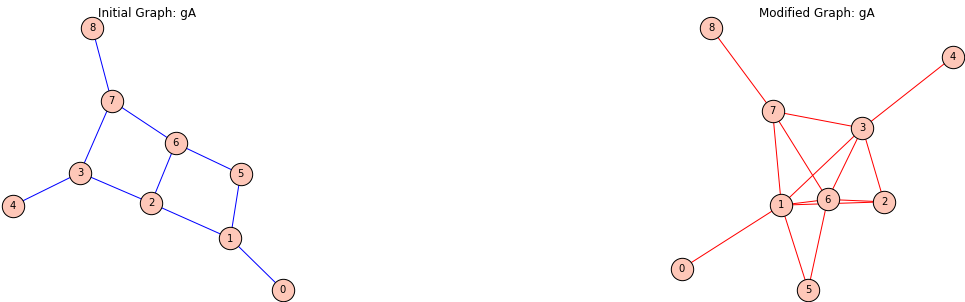

Graf: gB
Added edges: [(4, 6)]
Execution time: 1.8500 s




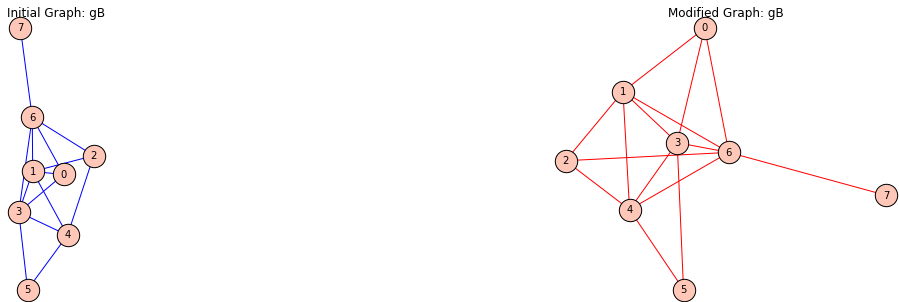

In [17]:
plot_ga('gA',Graph(gA))
plot_ga('gB',Graph(gB))

In [18]:
population_sizes = [20, 50, 100]
num_generations = [50, 100, 200]
selection_methods = ['r', 't']  # 'r' for roulette, 't' for tournament
selection_map = {
    'r': 'Roulette',
    't': 'Tournament'
}

In [19]:
def grid_search_ga(G, population_sizes, num_generations, selection_methods, selection_map):
    results = {}

    for population_size in population_sizes:
        for num_gen in num_generations:
            for selection_method in selection_methods:
                start_time = time.time()
                
                
                print(f"Population size: {population_size}, Number of generations: {num_gen}")
                print(f"Selection method: {selection_map[selection_method]}")
                
                best_individual, G_minimal = ga.genetic_algorithm(
                    G, 
                    population_size=population_size, 
                    num_generations=num_gen, 
                    mutation_rate=0.01, 
                    elitism_rate=0.1,
                    s=selection_method,
                    tournament_size=5
                )
                
                end_time = time.time()
                execution_time = end_time - start_time
                is_interval, _ = igc.check_interval_graph(G_minimal)
                
                if best_individual is not None:
                    added_edges = len(best_individual)
                    print(f"Number of added edges: {len(best_individual)}")
                    print(f"Added edges: {best_individual}")
                else:
                    added_edges = np.nan
                    print("No added edges")
                    
                print(f"Execution time: {execution_time:.4f} s")
                print(f"Is interval graph: {is_interval}")
                print("\n")
                
                results[(population_size, num_gen, selection_method)] = (added_edges, execution_time)

    return results

In [20]:
def plot_grid_search_ga(results, population_sizes, num_generations, selection_methods, selection_map):
    fig, axs = plt.subplots(2, len(selection_methods), figsize=(15, 10))
    
    for idx, selection_method in enumerate(selection_methods):
        added_edges_data = np.zeros((len(population_sizes), len(num_generations)))
        execution_time_data = np.zeros((len(population_sizes), len(num_generations)))

        for i, population_size in enumerate(population_sizes):
            for j, num_gen in enumerate(num_generations):
                added_edges, execution_time = results[(population_size, num_gen, selection_method)]
                added_edges_data[i, j] = added_edges
                execution_time_data[i, j] = execution_time

        # Plot added edges
        im1 = axs[0, idx].imshow(added_edges_data, cmap='viridis', origin='lower')
        axs[0, idx].set_title(f'Added Edges (Selection: {selection_map[selection_method]})')
        axs[0, idx].set_xlabel('Num Generations')
        axs[0, idx].set_ylabel('Population Size')
        axs[0, idx].set_xticks(range(len(num_generations)))
        axs[0, idx].set_xticklabels(num_generations)
        axs[0, idx].set_yticks(range(len(population_sizes)))
        axs[0, idx].set_yticklabels(population_sizes)
        fig.colorbar(im1, ax=axs[0, idx])

        # Annotate added edges
        for i in range(len(population_sizes)):
            for j in range(len(num_generations)):
                value = added_edges_data[i, j]
                axs[0, idx].text(j, i, f'{value:.1f}' if not np.isnan(value) else 'NaN',
                                 ha='center', va='center', color='white' if value < np.nanmax(added_edges_data) / 2 else 'black')

        # Plot execution time
        im2 = axs[1, idx].imshow(execution_time_data, cmap='plasma', origin='lower')
        axs[1, idx].set_title(f'Execution Time (Selection: {selection_map[selection_method]})')
        axs[1, idx].set_xlabel('Num Generations')
        axs[1, idx].set_ylabel('Population Size')
        axs[1, idx].set_xticks(range(len(num_generations)))
        axs[1, idx].set_xticklabels(num_generations)
        axs[1, idx].set_yticks(range(len(population_sizes)))
        axs[1, idx].set_yticklabels(population_sizes)
        fig.colorbar(im2, ax=axs[1, idx])

        # Annotate execution time
        for i in range(len(population_sizes)):
            for j in range(len(num_generations)):
                value = execution_time_data[i, j]
                axs[1, idx].text(j, i, f'{value:.2f}', ha='center', va='center', color='white' if value < np.max(execution_time_data) / 2 else 'black')

    plt.tight_layout()
    plt.show()

### Particle Swarm Optimization - plot

In [21]:
#Parameters
c_i_values = [0.1, 0.5, 1.0]
c_p_values = [1.0, 1.5, 2.0]
c_g_values = [1.0, 1.5, 2.0]

In [22]:
def grid_search_pso(G, swarm_size=30, num_iters=100, c_i_values=[0.1, 0.5, 1.0], c_p_values=[1.0, 1.5, 2.0], c_g_values=[1.0, 1.5, 2.0]):
    results = []
    
    # Generate all combinations of parameters
    param_combinations = list(itertools.product(c_i_values, c_p_values, c_g_values))

    for c_i, c_p, c_g in param_combinations:
        print(f"Testing parameters: c_i={c_i:.2f}, c_p={c_p:.2f}, c_g={c_g:.2f}")

        start_time = time.time()

        # Run PSO
        added_edges, G_minimal = pso.pso(G, swarm_size, c_i, c_p, c_g, num_iters)

        end_time = time.time()
        elapsed_time = end_time - start_time

        # Evaluate and record the results
        is_interval, _ = igc.check_interval_graph(G_minimal)
        results.append({
            'c_i': c_i,
            'c_p': c_p,
            'c_g': c_g,
            'added_edges': added_edges,
            'is_interval': is_interval,
            'execution_time': elapsed_time
        })
        if not added_edges:
            print("Initial graph is already an interval graph")
        else:
            print(f"Number of added edges: {len(added_edges)}")
            print(f"Added edges: {added_edges}")
        print(f"Execution time: {elapsed_time:.4f} s")
        print(f"Is interval graph: {is_interval}")
        print("\n")

    return results

In [23]:
def plot_grid_search_pso_results_num_edges(results, c_i_values, c_p_values, c_g_values):
    # Convert results to a DataFrame
    df = pd.DataFrame(results)
    
    # Ensure we have the expected columns
    if not {'c_i', 'c_p', 'c_g', 'added_edges'}.issubset(df.columns):
        raise ValueError("Results DataFrame must contain columns: 'c_i', 'c_p', 'c_g', 'added_edges'")
    
    # Convert the DataFrame to have numeric columns only
    df = df[['c_i', 'c_p', 'c_g', 'added_edges']]
    df['added_edges'] = df['added_edges'].apply(len)
    
    # Create the pivot table
    pivot_edges = df.pivot_table(index=['c_i', 'c_p'], columns='c_g', values='added_edges', aggfunc='mean', fill_value=0)
        
    # Generate labels
    c_i_labels = sorted(set(df['c_i']))
    c_p_labels = sorted(set(df['c_p']))
    c_g_labels = sorted(set(df['c_g']))
    
    # Ensure all expected combinations are present
    for c_i in c_i_values:
        for c_p in c_p_values:
            if (c_i, c_p) not in pivot_edges.index:
                pivot_edges.loc[(c_i, c_p)] = [0] * len(c_g_values)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Handle empty pivot table case
    if pivot_edges.empty:
        print("Pivot table is empty. Check input data.")
        return
    
    im = ax.imshow(pivot_edges, cmap='viridis', interpolation='nearest')

    # Set the x-axis (c_g) tick labels with two decimal places
    ax.set_xticks(np.arange(len(c_g_labels)))
    ax.set_xticklabels([f"{label:.2f}" for label in c_g_labels])

    # Set the y-axis (c_i, c_p) tick labels with two decimal places
    ax.set_yticks(np.arange(len(pivot_edges.index)))
    ax.set_yticklabels([f"{i:.2f},{p:.2f}" for i, p in pivot_edges.index])

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(pivot_edges.index)):
        for j in range(len(c_g_labels)):
            text = ax.text(j, i, f"{pivot_edges.iloc[i, j]:.2f}",
                           ha="center", va="center", color="w")

    ax.set_xlabel('c_g')
    ax.set_ylabel('c_i, c_p')
    ax.set_title('Number of Added Edges Heatmap for PSO Parameters')
    fig.tight_layout()
    plt.colorbar(im, ax=ax, orientation='vertical')

    plt.show()

In [24]:
def plot_grid_search_pso_results_execution_time(results, c_i_values, c_p_values, c_g_values):
    # Convert results to a DataFrame
    df = pd.DataFrame(results)
    
    # Pivot tables for heatmaps
    pivot_time = df.pivot_table(index=['c_i', 'c_p'], columns='c_g', values='execution_time', aggfunc='mean')

    fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    c_i_labels = sorted(set(df['c_i']))
    c_p_labels = sorted(set(df['c_p']))
    c_g_labels = sorted(set(df['c_g']))

    im = ax.imshow(pivot_time, cmap='viridis', interpolation='nearest')

    # Set the x-axis (c_g) tick labels with two decimal places
    ax.set_xticks(np.arange(len(c_g_labels)))
    ax.set_xticklabels([f"{label:.2f}" for label in c_g_labels])

    # Set the y-axis (c_i, c_p) tick labels with two decimal places
    ax.set_yticks(np.arange(len(c_i_labels) * len(c_p_labels)))
    ax.set_yticklabels([f"{i:.2f},{p:.2f}" for i, p in pivot_time.index])

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(c_i_labels) * len(c_p_labels)):
        for j in range(len(c_g_labels)):
            text = ax.text(j, i, f"{pivot_time.iloc[i, j]:.2f}",
                           ha="center", va="center", color="w")

    ax.set_xlabel('c_g')
    ax.set_ylabel('c_i, c_p')
    ax.set_title('Execution Time Heatmap for PSO Parameters')
    fig.tight_layout()
    plt.colorbar(im, ax=ax, orientation='vertical')

    plt.show()


## Testing algorithms on random graphs 

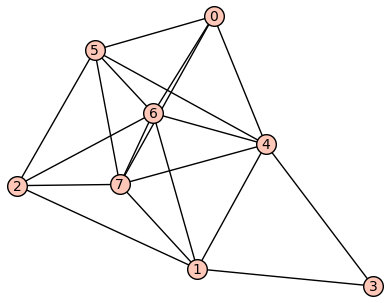

In [25]:
n = 8  # Number of vertices
p = 0.6  # Probability of edge creation

G = graphs.RandomGNP(n, p)
while not G.is_connected():
    G = graphs.RandomGNP(n, p)
    
G.show()

S-metaheuristics plot

Simulated annealing


Initial graph: [(0, 4), (0, 5), (0, 6), (0, 7), (1, 2), (1, 3), (1, 4), (1, 6), (1, 7), (2, 5), (2, 6), (2, 7), (3, 4), (4, 5), (4, 6), (4, 7), (5, 6), (5, 7), (6, 7)]
Added edges: [(1, 5)]
Execution time: 5.5398 s




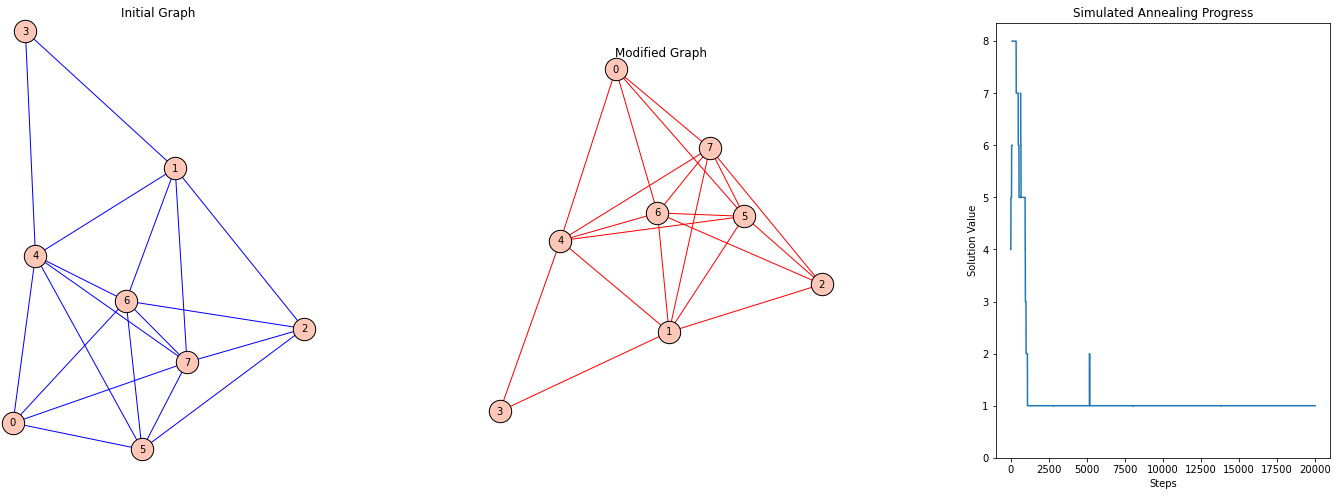

Simulated annealing - cooling


Cooling Method: linear_multiplicative
t_max=1000, Best Number of Added Edges: 1, Acceptance rate: 0.9838556505223172
Execution time: 0.3968 s
-------------------------------
Cooling Method: linear_multiplicative
t_max=5000, Best Number of Added Edges: 1, Acceptance rate: 0.9544072948328267
Execution time: 2.0527 s
-------------------------------
Cooling Method: natural_log_exponential_multiplicative
t_max=1000, Best Number of Added Edges: 1, Acceptance rate: 0.9411764705882353
Execution time: 0.0503 s
-------------------------------
Cooling Method: natural_log_exponential_multiplicative
t_max=5000, Best Number of Added Edges: 1, Acceptance rate: 0.8809523809523809
Execution time: 0.0613 s
-------------------------------
Cooling Method: logarithmic_multiplicative
t_max=1000, Best Number of Added Edges: 1, Acceptance rate: 0.63635
Execution time: 7.9724 s
-------------------------------
Cooling Method: logarithmic_multiplicative
t_max=5000, Best Number of 

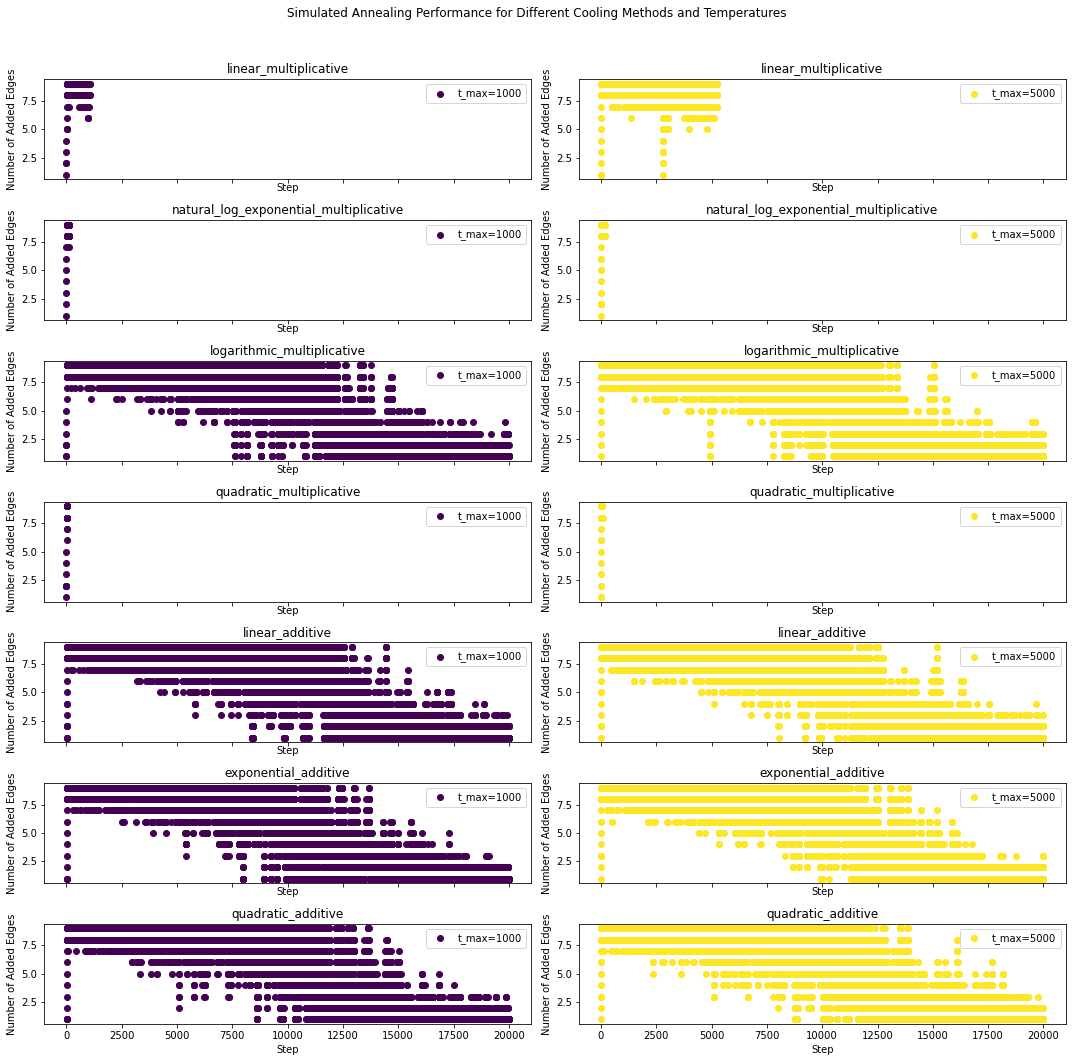

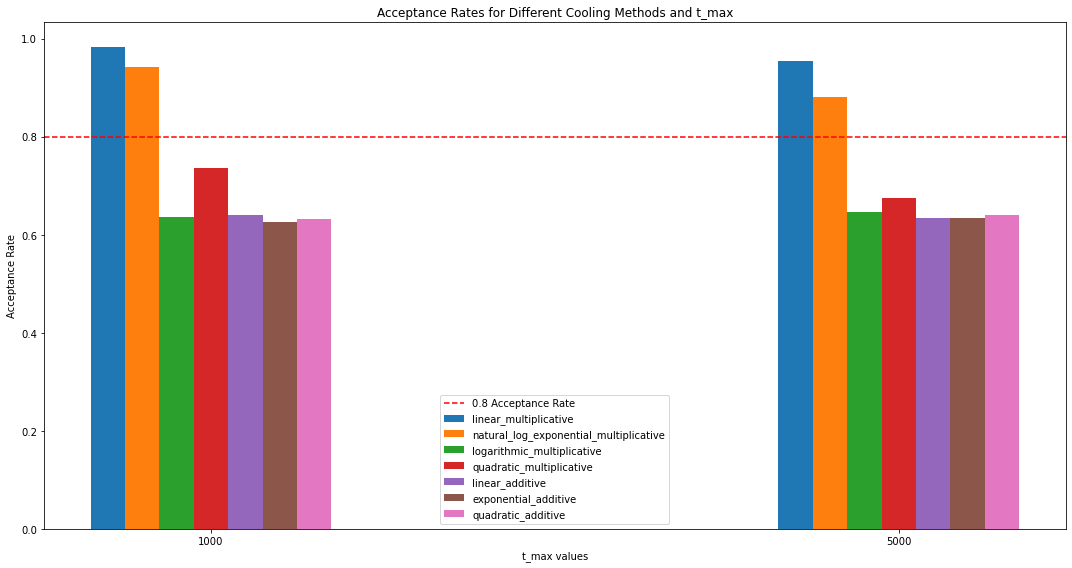

VNS


Time limit: 10
Solution: [(1, 5)], Value: 1, Number of iterations: 740


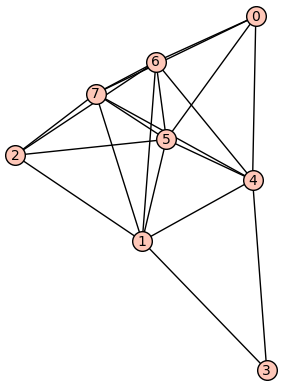

-------------------------------------------------
Time limit: 20
Solution: [(1, 5)], Value: 1, Number of iterations: 1570


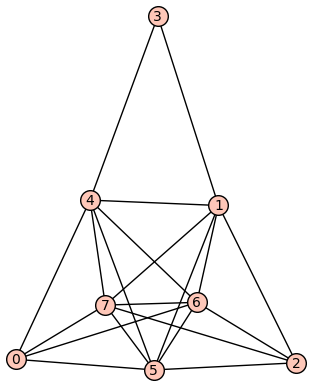

-------------------------------------------------
Time limit: 30
Solution: [(1, 5)], Value: 1, Number of iterations: 2345


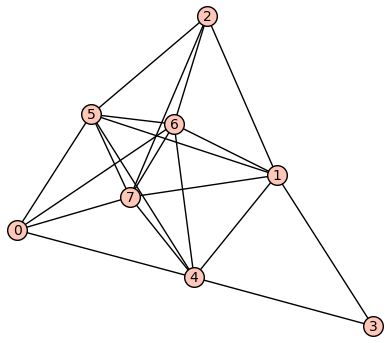

-------------------------------------------------


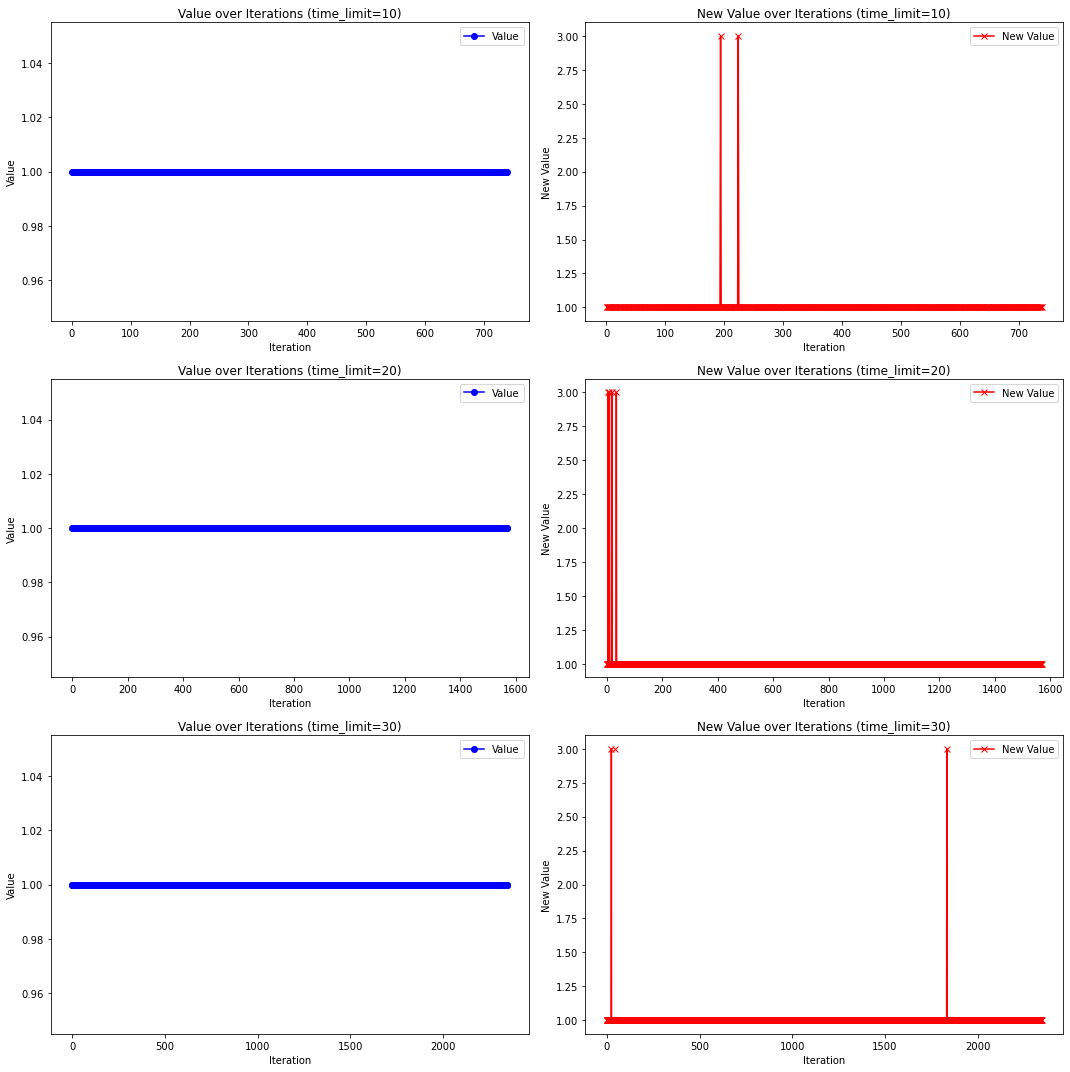

In [26]:
plot_sa(G)

plot_sa_cooling(G, cooling_params)

plot_vns(G, vns_params)

Genetics algorithm plot

Population size: 20, Number of generations: 50
Selection method: Roulette
Number of added edges: 1
Added edges: [(1, 5)]
Execution time: 0.3775 s
Is interval graph: True


Population size: 20, Number of generations: 50
Selection method: Tournament
Number of added edges: 1
Added edges: [(1, 5)]
Execution time: 0.3030 s
Is interval graph: True


Population size: 20, Number of generations: 100
Selection method: Roulette
Number of added edges: 1
Added edges: [(1, 5)]
Execution time: 0.7376 s
Is interval graph: True


Population size: 20, Number of generations: 100
Selection method: Tournament
Number of added edges: 1
Added edges: [(1, 5)]
Execution time: 0.7814 s
Is interval graph: True


Population size: 20, Number of generations: 200
Selection method: Roulette
Number of added edges: 1
Added edges: [(1, 5)]
Execution time: 1.6092 s
Is interval graph: True


Population size: 20, Number of generations: 200
Selection method: Tournament
Number of added edges: 1
Added edges: [(1, 5)]
Execution

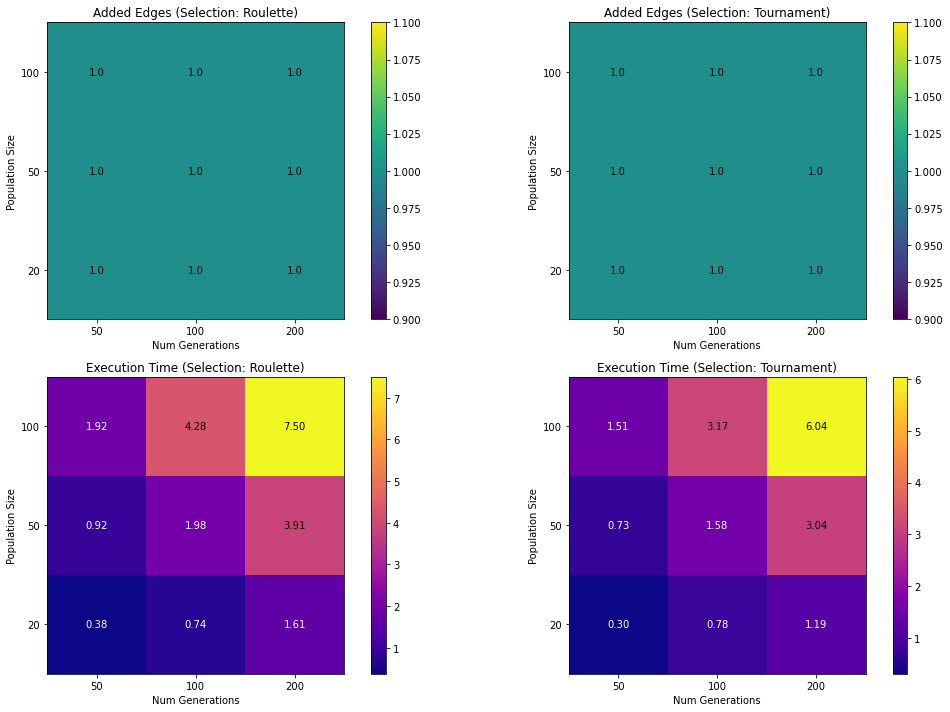

In [27]:
# Generate the results for the grid search
results_ga = grid_search_ga(G, population_sizes, num_generations, selection_methods, selection_map)

# Plot the results
plot_grid_search_ga(results_ga, population_sizes, num_generations, selection_methods, selection_map)

Particle swarm optimization plot

Testing parameters: c_i=0.10, c_p=1.00, c_g=1.00
Number of added edges: 1
Added edges: [(1, 5)]
Execution time: 1.6562 s
Is interval graph: True


Testing parameters: c_i=0.10, c_p=1.00, c_g=1.50
Number of added edges: 2
Added edges: [(0, 5), (1, 5)]
Execution time: 1.5891 s
Is interval graph: True


Testing parameters: c_i=0.10, c_p=1.00, c_g=2.00
Number of added edges: 4
Added edges: [(0, 5), (0, 1), (2, 7), (1, 5)]
Execution time: 1.4601 s
Is interval graph: True


Testing parameters: c_i=0.10, c_p=1.50, c_g=1.00
Number of added edges: 2
Added edges: [(1, 3), (1, 5)]
Execution time: 1.5401 s
Is interval graph: True


Testing parameters: c_i=0.10, c_p=1.50, c_g=1.50
Number of added edges: 4
Added edges: [(4, 5), (0, 1), (1, 5), (1, 4)]
Execution time: 1.7266 s
Is interval graph: True


Testing parameters: c_i=0.10, c_p=1.50, c_g=2.00
Number of added edges: 3
Added edges: [(0, 1), (0, 4), (1, 5)]
Execution time: 1.5189 s
Is interval graph: True


Testing parameters: c_i=0.10, c_p=2.00

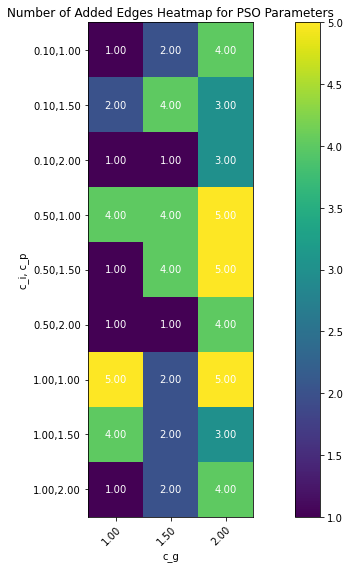

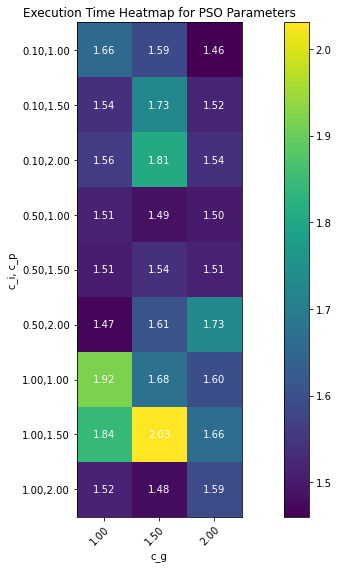

In [28]:
# Generate the results for the grid search
results_pso = grid_search_pso(G, swarm_size=30, num_iters=100, c_i_values=c_i_values, c_p_values=c_p_values, c_g_values=c_g_values)

# Plot the results
plot_grid_search_pso_results_num_edges(results_pso, c_i_values, c_p_values, c_g_values)
plot_grid_search_pso_results_execution_time(results_pso, c_i_values, c_p_values, c_g_values)